## Практическое задание 2. Метод Зейделя

In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt

### Наивное решение

In [2]:
def slow_seidel_method(A, b, accuracy=0.001, max_iter=10000):
    n = A.shape[0]
    x = np.zeros(n)
    iterations = 0
    accuracy_history = []

    while True:
        iterations += 1
        x_prev = x.copy()
        
        for i in range(n):
            x[i] = 0
            
            for j in range(n):
                if i != j:
                    x[i] -= x[j] * A[i, j] / A[i, i]
                    
            x[i] += b[i] / A[i, i]
        
        # Check accuracy
        current_accuracy = np.linalg.norm(A.dot(x) - b)
        accuracy_history.append(current_accuracy)
        
        if current_accuracy <= accuracy:
            break

        if iterations > max_iter:
            print('Max iterations exceeded')
            break
    
    return x, iterations, accuracy_history

### Оптимизированное решение

In [3]:
def seidel_method(A, b, accuracy=0.001, max_iter=10000):
    n = A.shape[0]
    x = np.zeros(n)
    iterations = 0
    accuracy_history = []
    
    # Pre calculating coefficients
    C = -A / np.diag(A)[:, None]
    np.fill_diagonal(C, 0)
    
    d = b / np.diag(A)
    
    while True:
        iterations += 1
        x_prev = x.copy()
        
        for i in range(n):
            x[i] = C[i, :].dot(x) + d[i]

        # Check accuracy
        current_accuracy = np.linalg.norm(A.dot(x) - b)
        accuracy_history.append(current_accuracy)
        
        if current_accuracy <= accuracy:
            break
            
        if iterations > max_iter:
            print('Max iterations exceeded')
            break
    
    return x, iterations, accuracy_history

In [4]:
def generate_system(size, cond):
    A = np.random.uniform(0, 1, (size, size))
    A = A.dot(A.T) + np.eye(size) * cond
#     print(np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A)))
    b = np.random.uniform(0, 1, size)
    return A, b

### Сравнение скорости решений

In [5]:
size = 200
A, b = generate_system(size, size)

start_time = time.time()

x, iter, hist = slow_seidel_method(A, b)

print('Naive implementation:',
      '\nTime: ', (time.time() - start_time),
      '\nIterations: ', iter,
      '\nAccuracy: ', np.linalg.norm(A.dot(x) - b))

Naive implementation: 
Time:  15.463016986846924 
Iterations:  462 
Accuracy:  0.0009954987971874424


In [6]:
start_time = time.time()

x, iter, hist = seidel_method(A, b)

print('Optimized implementation:',
    '\nTime: ', (time.time() - start_time),
      '\nIterations: ', iter,
     '\nAccuracy: ', np.linalg.norm(A.dot(x) - b))

Optimized implementation: 
Time:  0.22186589241027832 
Iterations:  462 
Accuracy:  0.000995498797187133


### Тестирование метода

Скорость сходимости в зависимости от обусловленности матрицы.

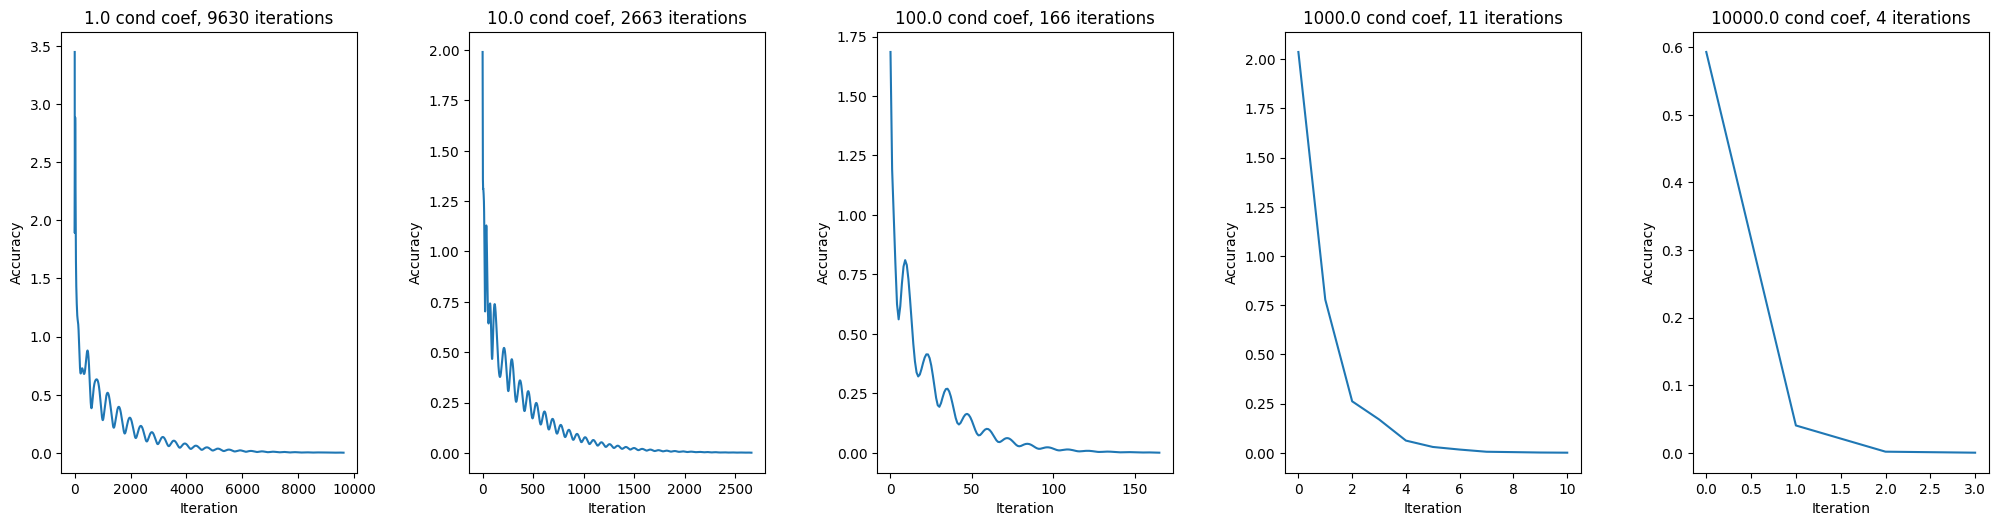

In [7]:
size = 100
steps = 5

fig, ax = plt.subplots(1, steps)
fig.set_size_inches((steps * 4, 5))
fig.tight_layout(h_pad=5, w_pad=5)

for i, cond in enumerate(np.logspace(0, 4, steps)):
    A, b = generate_system(size, cond)
    x, iter, hist = seidel_method(A, b)
    ax[i].plot(hist)
    ax[i].set_title(f'{cond} cond coef, {iter} iterations')
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel('Accuracy')

### Метод Гаусса

In [8]:
def gauss_method(A, b):
    n = len(b)
    C = A.copy()
    d = b.copy()
    
    # Convert ot upper-triangle
    for i in range(0, n - 1):
        for j in range(i + 1, n):
            if C[j, i] != 0:
                r = C[j, i] / C[i, i]
                C[j, i + 1:] = C[j, i + 1:] - r * C[i, i + 1:]
                d[j] = d[j] - r * d[i]
                
    x = np.zeros((n))
    
    # Solve upper-triangle
    for i in range(n - 1, -1, -1):
        x[i] = (d[i] - C[i, i + 1:].dot(x[i + 1:])) / C[i, i]
    
    return x

In [9]:
# Test
A, b = generate_system(100, 1)
x = gauss_method(A, b)
x_true = np.linalg.solve(A, b)
print('Error: ', np.linalg.norm(x - x_true) / np.linalg.norm(x_true))

Error:  1.453595281985753e-14


### Симметричный метод Зейделя

In [10]:
# def symmetrical_seidel_method(A, b, accuracy=0.0001, max_iter=10000):
#     n = A.shape[0]
#     x = np.zeros(n)
#     iterations = 0
#     accuracy_history = []
    
#     L = np.tril(A, -1)
#     U = np.triu(A, 1)
#     D = np.diag(np.diag(A))

#     while True:
#         iterations += 1
#         if iterations % 2 == 1:
#             x = np.linalg.inv(D + L).dot(-U.dot(x) + b)
#         else:
#             x = np.linalg.inv(D + U).dot(-L.dot(x) + b)
        
#         # Check accuracy
#         current_accuracy = np.linalg.norm(A.dot(x) - b)
#         accuracy_history.append(current_accuracy)
        
#         if current_accuracy <= accuracy:
#             break
            
#         if iterations > max_iter:
#             print('Max iterations exceeded')
#             break
    
#     return x, iterations, accuracy_history


def symmetrical_seidel_method(A, b, accuracy=0.0001, max_iter=10000):
    n = A.shape[0]
    x = np.zeros(n)
    iterations = 0
    accuracy_history = []
    
    # Pre calculating coefficients
    C = -A / np.diag(A)[:, None]
    np.fill_diagonal(C, 0)
    
    d = b / np.diag(A)
    
    while True:
        iterations += 1
        x_prev = x.copy()
        
        if iterations % 2 == 1:
            for i in range(n):
                x[i] = C[i, :].dot(x) + d[i]
        else:
            for i in range(n - 1, -1, -1):
                x[i] = C[i, :].dot(x) + d[i]

        # Check accuracy
        current_accuracy = np.linalg.norm(A.dot(x) - b)
        accuracy_history.append(current_accuracy)
        
        if current_accuracy <= accuracy:
            break
            
        if iterations > max_iter:
            print('Max iterations exceeded')
            break
    
    return x, iterations, accuracy_history


# def symmetrical_seidel_method(A, b, accuracy=0.001, max_iter=10000):
#     n = A.shape[0]
#     x = np.zeros(n)
#     iterations = 0
#     accuracy_history = []

#     while True:
#         iterations += 1
#         x_prev = x.copy()
        
#         if iterations % 2 == 1:
#             for i in range(n):
#                 x[i] = 0

#                 for j in range(n):
#                     if i != j:
#                         x[i] -= x[j] * A[i, j] / A[i, i]

#                 x[i] += b[i] / A[i, i]
#         else:
#             for i in range(n - 1, -1, -1):
#                 x[i] = 0

#                 for j in range(n):
#                     if i != j:
#                         x[i] -= x[j] * A[i, j] / A[i, i]

#                 x[i] += b[i] / A[i, i]
        
#         # Check accuracy
#         current_accuracy = np.linalg.norm(A.dot(x) - b)
#         accuracy_history.append(current_accuracy)
        
#         if current_accuracy <= accuracy:
#             break

#         if iterations > max_iter:
#             print('Max iterations exceeded')
#             break
    
#     return x, iterations, accuracy_history

### Сравнение Метода Гаусса с методами Зейделя


Size:  10
Method       Error
Seidel:      0.00035986062178137496
Symm Seidel: 4.656070952437254e-05
Gauss:       1.8315103030749225e-16

Size:  60
Method       Error
Seidel:      0.0003127496756055064
Symm Seidel: 2.4289876378712517e-05
Gauss:       6.052328614251236e-16

Size:  110
Method       Error
Seidel:      0.00025964987237220847
Symm Seidel: 1.7950669511237075e-05
Gauss:       7.963744613285106e-16

Size:  160
Method       Error
Seidel:      0.00026998433910532327
Symm Seidel: 1.524154011030808e-05
Gauss:       9.266761093176253e-16

Size:  210
Method       Error
Seidel:      0.00023983383905616196
Symm Seidel: 1.3885454927770605e-05
Gauss:       1.193766774249709e-15

Size:  260
Method       Error
Seidel:      0.00021176059813049453
Symm Seidel: 1.2115876615027626e-05
Gauss:       1.4868678582207118e-15


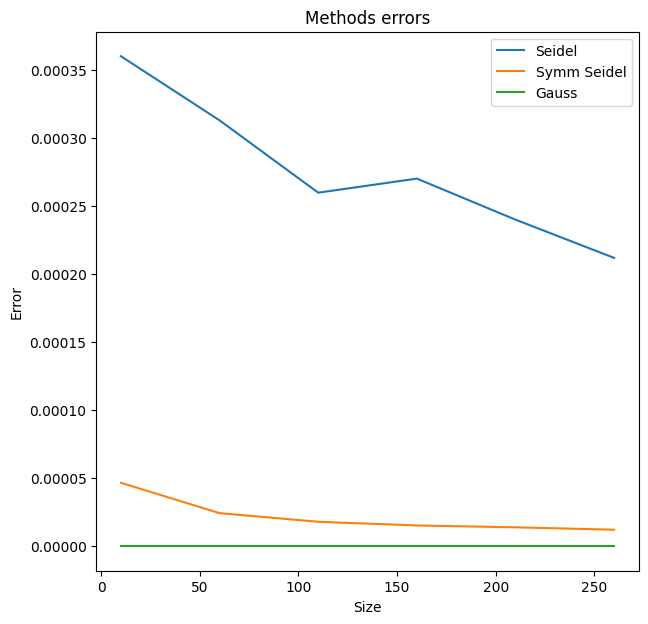

In [14]:
sizes = np.arange(10, 300, 50)

seidel_errors = []
symm_seidel_errors = []
gauss_errors = []

for size in sizes:
    print('\nSize: ', size)
    print('Method       Error')
    A, b = generate_system(size, size)
    x_true = np.linalg.solve(A, b)
    
    x, iter, hist = seidel_method(A, b)
    error = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    seidel_errors.append(error)
    print('Seidel:     ', error)
    
    x, iter, hist = symmetrical_seidel_method(A, b)
    error = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    symm_seidel_errors.append(error)
    print('Symm Seidel:', error)
    
    x = gauss_method(A, b)
    error = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    gauss_errors.append(error)
    print('Gauss:      ', error)

plt.figure(figsize=(7, 7))
plt.plot(sizes, seidel_errors)
plt.plot(sizes, symm_seidel_errors)
plt.plot(sizes, gauss_errors)
plt.title('Methods errors')
plt.xlabel('Size')
plt.ylabel('Error')
plt.legend(['Seidel', 'Symm Seidel', 'Gauss'])

### Сравнение симметричного и обычного методов Зейделя

Max iterations exceeded
Max iterations exceeded


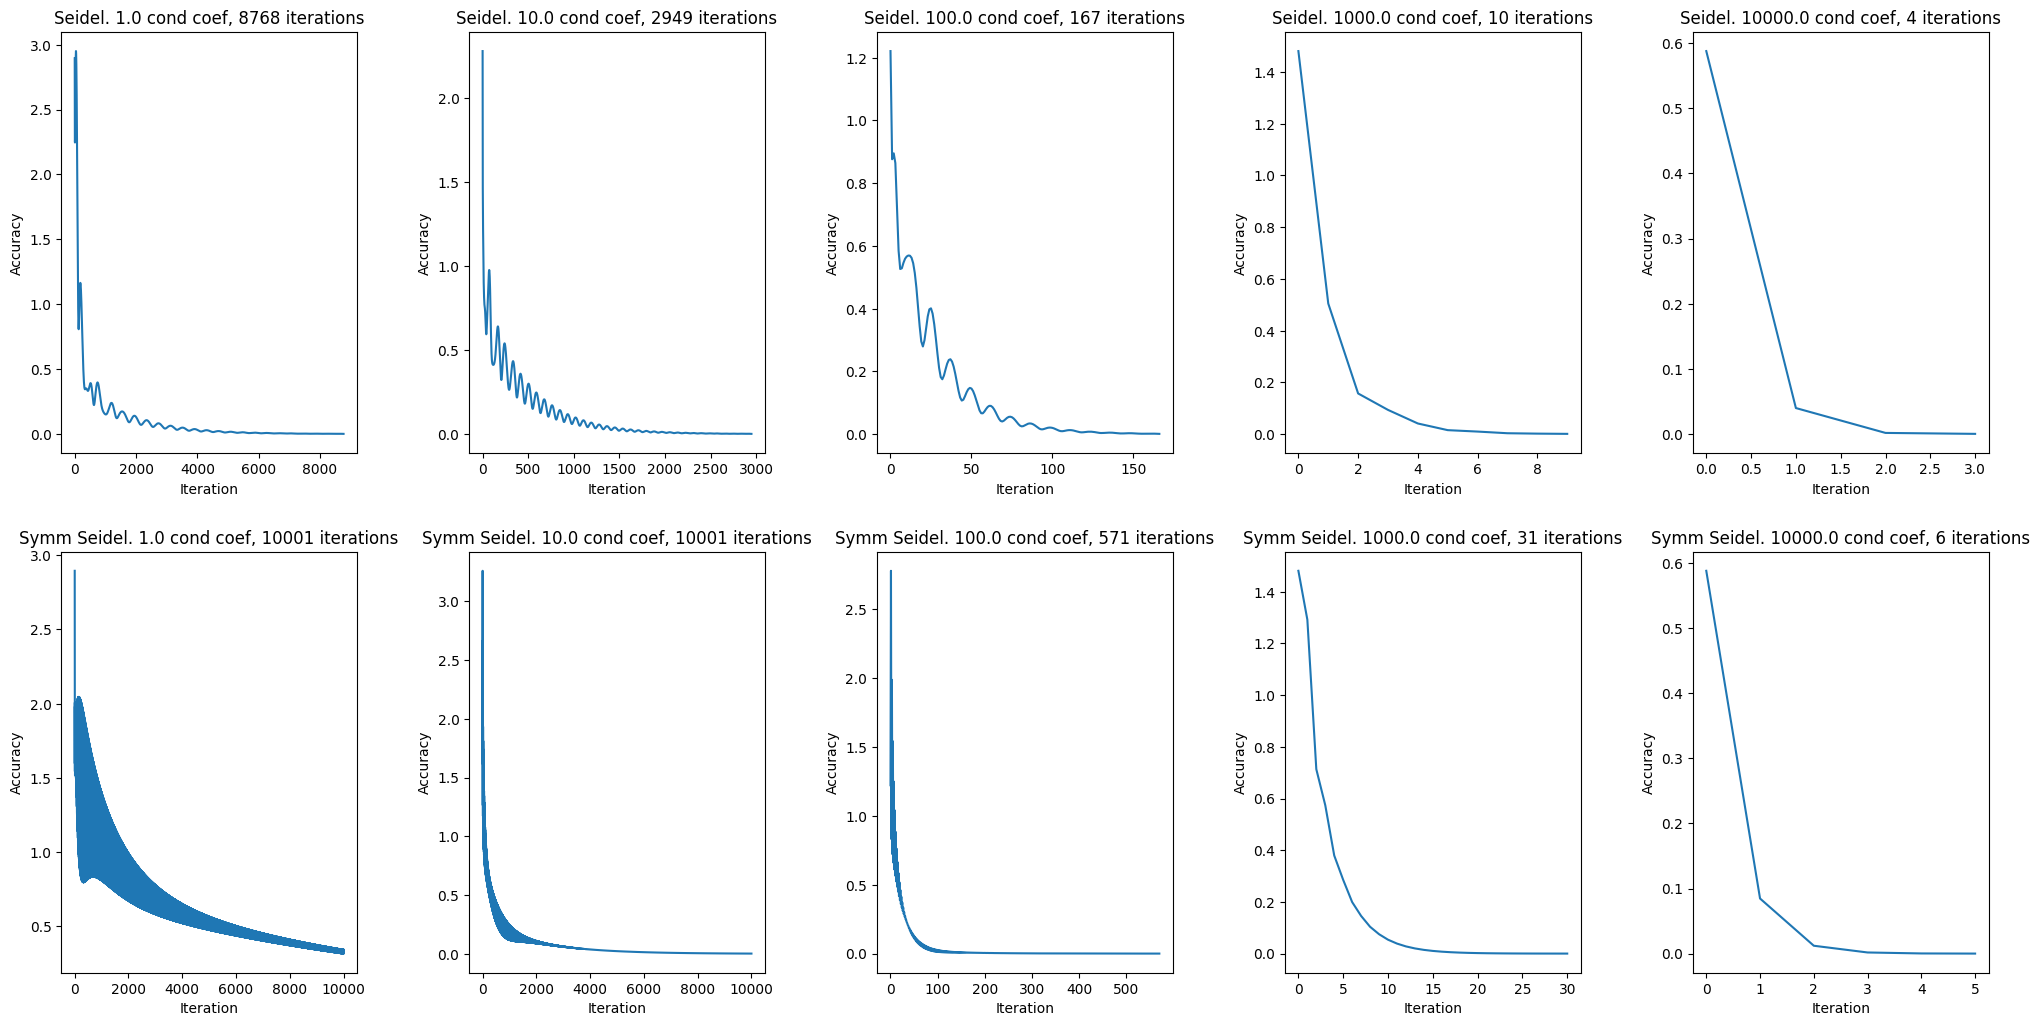

In [12]:
size = 100
steps = 5

fig, ax = plt.subplots(2, steps)
fig.set_size_inches((steps * 4, 10))
fig.tight_layout(h_pad=5, w_pad=5)

for i, cond in enumerate(np.logspace(0, 4, steps)):
    A, b = generate_system(size, cond)
    x, iter, hist = seidel_method(A, b)
    ax[0, i].plot(hist)
    ax[0, i].set_title(f'Seidel. {cond} cond coef, {iter} iterations')
    ax[0, i].set_xlabel('Iteration')
    ax[0, i].set_ylabel('Accuracy')
    
    x, iter, hist = symmetrical_seidel_method(A, b)
    ax[1, i].plot(hist)
    ax[1, i].set_title(f'Symm Seidel. {cond} cond coef, {iter} iterations')
    ax[1, i].set_xlabel('Iteration')
    ax[1, i].set_ylabel('Accuracy')

In [15]:
x, iter, hist = symmetrical_seidel_method(A, b)

print('Naive implementation:',
      '\nIterations: ', iter,
     '\nAccuracy: ', np.linalg.norm(A.dot(x) - b))

x, iter, hist = seidel_method(A, b)

print('Naive implementation:',
      '\nIterations: ', iter,
     '\nAccuracy: ', np.linalg.norm(A.dot(x) - b))

Naive implementation: 
Iterations:  3741 
Accuracy:  9.976537080980786e-05
Naive implementation: 
Iterations:  910 
Accuracy:  0.000988529682568017
